### 모델 개요

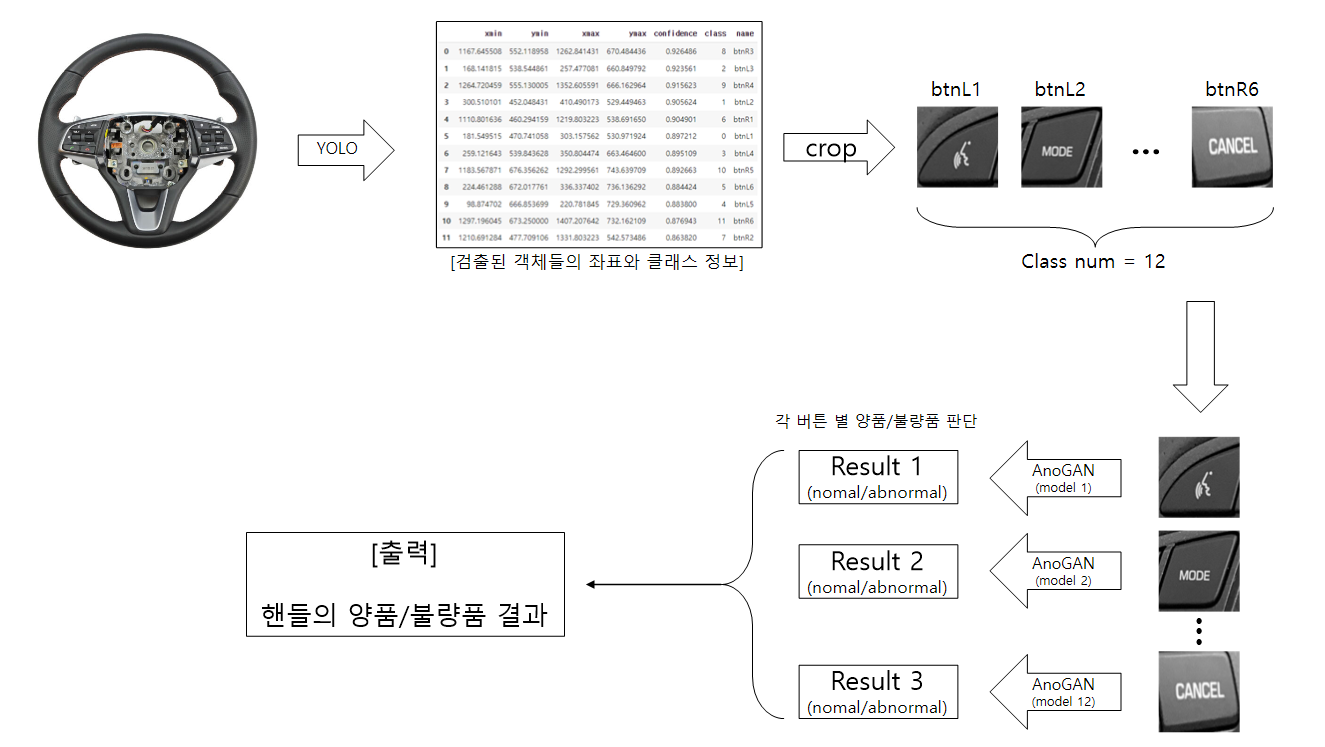

### 모델 2와의 차이점 : 버튼별 불량을 판별할 때 오토인코더를 사용하였음

1. 핸들의 전체 이미지를 YOLO의 인풋 이미지로 사용
2. YOLO의 결과를 바탕으로 인풋 이미지에서 각 버튼의 이미지를 crop
3. crop한 이미지를 각각의 AutoEncoder 모델에 입력으로 사용하여 버튼의 이상치를 판별
4. 12개의 버튼의 판별 결과를 바탕으로 핸들의 양품/불량품 판별 결과를 출력

# 결과

In [ ]:
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [ ]:
# yolo weight 저장 경로
weight_path = '/content/drive/MyDrive/DSBA_최종프로젝트_1조/최종_프로젝트/result/best.pt'

model = torch.hub.load("ultralytics/yolov5", "custom", path=weight_path, force_reload=True)

/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: YOLOv5 requirement "ipython" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheel

오토 인코더 모델구조
* 인코더 : input_layer(16384) > layer1(4096) > layer2(1024) > layer3(512)
* 디코더 : layer1(1024) > layer2(4096)> output_layer(16384)

In [ ]:
# L1 ~ L6, R1 ~ R6 모든 모델을 로드 및 저장
# 코랩 런타임에서 고용량 RAM을 설정 안하면 로드 중에 터져버림
AE_L1 = keras.models.load_model('/content/drive/MyDrive/DSBA_최종프로젝트_1조/최종_프로젝트/인타운_멘토링/버튼별_오토인코더_결과/AE_L1.h5')
AE_L2 = keras.models.load_model('/content/drive/MyDrive/DSBA_최종프로젝트_1조/최종_프로젝트/인타운_멘토링/버튼별_오토인코더_결과/AE_L2.h5')
AE_L3 = keras.models.load_model('/content/drive/MyDrive/DSBA_최종프로젝트_1조/최종_프로젝트/인타운_멘토링/버튼별_오토인코더_결과/AE_L3.h5')
AE_L4 = keras.models.load_model('/content/drive/MyDrive/DSBA_최종프로젝트_1조/최종_프로젝트/인타운_멘토링/버튼별_오토인코더_결과/AE_L4.h5')
AE_L5 = keras.models.load_model('/content/drive/MyDrive/DSBA_최종프로젝트_1조/최종_프로젝트/인타운_멘토링/버튼별_오토인코더_결과/AE_L5.h5')
AE_L6 = keras.models.load_model('/content/drive/MyDrive/DSBA_최종프로젝트_1조/최종_프로젝트/인타운_멘토링/버튼별_오토인코더_결과/AE_L6.h5')

AE_R1 = keras.models.load_model('/content/drive/MyDrive/DSBA_최종프로젝트_1조/최종_프로젝트/인타운_멘토링/버튼별_오토인코더_결과/AE_R1.h5')
AE_R2 = keras.models.load_model('/content/drive/MyDrive/DSBA_최종프로젝트_1조/최종_프로젝트/인타운_멘토링/버튼별_오토인코더_결과/AE_R2.h5')
AE_R3 = keras.models.load_model('/content/drive/MyDrive/DSBA_최종프로젝트_1조/최종_프로젝트/인타운_멘토링/버튼별_오토인코더_결과/AE_R3.h5')
AE_R4 = keras.models.load_model('/content/drive/MyDrive/DSBA_최종프로젝트_1조/최종_프로젝트/인타운_멘토링/버튼별_오토인코더_결과/AE_R4.h5')
AE_R5 = keras.models.load_model('/content/drive/MyDrive/DSBA_최종프로젝트_1조/최종_프로젝트/인타운_멘토링/버튼별_오토인코더_결과/AE_R5.h5')
AE_R6 = keras.models.load_model('/content/drive/MyDrive/DSBA_최종프로젝트_1조/최종_프로젝트/인타운_멘토링/버튼별_오토인코더_결과/AE_R6.h5')

In [ ]:
# 오토인코더 모델 summary
# AE_L1.summary()

In [ ]:
img = cv2.imread('/content/drive/MyDrive/프로젝트_개인/최종정리/abnomal_images/KakaoTalk_20221108_173211513_11.jpg')

# yolo에 img를 인폿으로 입력한 결과를 results 변수에 저장
results = model(img, size=640)

In [ ]:
# results를 pandas dataframe으로 변환한 후 중복검출된 결과를 삭제
result_df = pd.DataFrame(results.pandas().xyxy[-1])
result_df = result_df.drop_duplicates(['name'], keep='first')

# 클래스 번호순으로 재정렬
result_df = result_df.sort_values(by='class')
result_df = result_df.reset_index(drop=True)

In [ ]:
# 원본 버튼 이미지가 담기는 리스트
detected_btn = []

# 오토 인코더 결과 이미지가 담기는 리스트
AE_result_imgs = []

for i in range(12):

    # 욜로 결과값을 바탕으로 버튼 이미지를 잘라와서 128*128 사이즈로 reshape 후 오토인코더에 입력으로 사용
    row = result_df.loc[i, :].values.tolist()

    x1, y1, x2, y2 = int(row[0]), int(row[1]), int(row[2]), int(row[3])

    ae_input_img = img[y1:y2, x1:x2].astype('float32')
    ae_input_img = cv2.resize(ae_input_img, [128, 128])
    ae_input_img = cv2.cvtColor(ae_input_img, cv2.COLOR_BGR2GRAY)
    ae_input_img = ae_input_img.flatten()/255

    detected_btn.append(ae_input_img)

    if row[5] == 0:
        AE_RESULT = AE_L1.predict(ae_input_img.reshape(1, -1))
        AE_result_imgs.append(AE_RESULT)
    
    elif row[5] == 1:
        AE_RESULT = AE_L2.predict(ae_input_img.reshape(1, -1))
        AE_result_imgs.append(AE_RESULT)
    
    elif row[5] == 2:
        AE_RESULT = AE_L3.predict(ae_input_img.reshape(1, -1))
        AE_result_imgs.append(AE_RESULT)

    elif row[5] == 3:
        AE_RESULT = AE_L4.predict(ae_input_img.reshape(1, -1))
        AE_result_imgs.append(AE_RESULT)

    elif row[5] == 4:
        AE_RESULT = AE_L5.predict(ae_input_img.reshape(1, -1))
        AE_result_imgs.append(AE_RESULT)

    elif row[5] == 5:
        AE_RESULT = AE_L6.predict(ae_input_img.reshape(1, -1))
        AE_result_imgs.append(AE_RESULT)

    elif row[5] == 6:
        AE_RESULT = AE_R1.predict(ae_input_img.reshape(1, -1))
        AE_result_imgs.append(AE_RESULT)

    elif row[5] == 7:
        AE_RESULT = AE_R2.predict(ae_input_img.reshape(1, -1))
        AE_result_imgs.append(AE_RESULT)

    elif row[5] == 8:
        AE_RESULT = AE_R3.predict(ae_input_img.reshape(1, -1))
        AE_result_imgs.append(AE_RESULT)

    elif row[5] == 9:
        AE_RESULT = AE_R4.predict(ae_input_img.reshape(1, -1))
        AE_result_imgs.append(AE_RESULT)

    elif row[5] == 10:
        AE_RESULT = AE_R5.predict(ae_input_img.reshape(1, -1))
        AE_result_imgs.append(AE_RESULT)

    elif row[5] == 11:
        AE_RESULT = AE_R6.predict(ae_input_img.reshape(1, -1))
        AE_result_imgs.append(AE_RESULT)

1/1 [==============================] - 0s 81ms/step


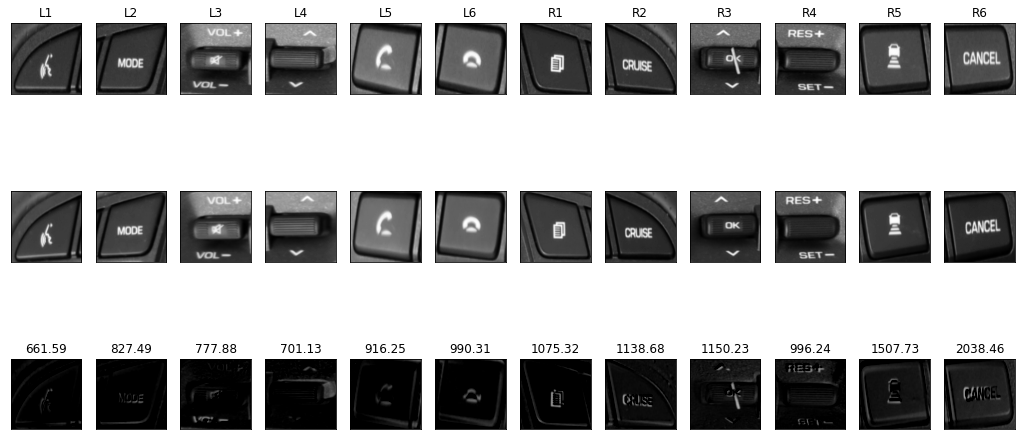

In [ ]:
classes = ['L1', 'L2', 'L3', 'L4', 'L5', 'L6',
           'R1', 'R2', 'R3', 'R4', 'R5', 'R6']

n = 12  # 결과 그래프에 보여줄 열 개수
plt.figure(figsize=(18, 18))
for i in range(n):

    # 원본(잘라온 버튼 이미지) 출력
    ax = plt.subplot(6, n, i + 1)
    plt.imshow(detected_btn[i].reshape(128, 128))
    plt.title(classes[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 오토인코더 output 출력
    ax = plt.subplot(6, n, i + 1 + n)
    plt.imshow(AE_result_imgs[i][0].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # (원본) - (오토인코더 출력)
    ax = plt.subplot(6, n, i + 1 + 2*n)
    plt.imshow((detected_btn[i] - AE_result_imgs[i][0]).reshape(128, 128), vmin=0, vmax=1)
    # |(원본) - (오토인코더 출력)| 의 합을 제목으로 사용
    # | | : 절대값
    plt.title(round(sum(abs(detected_btn[i] - AE_result_imgs[i][0])), 2))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()